In [1]:
import os
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
print(os.listdir("C:/Users/오원석/user_name/elo-merchant-category-recommendation"))

['Data_Dictionary.xlsx', 'historical_transactions.csv', 'merchants.csv', 'new_merchant_transactions.csv', 'sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
#conda install -c conda-forge workalendar

In [3]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings

import workalendar
from workalendar.america import Brazil

warnings.filterwarnings('ignore')
np.random.seed(4590)

In [22]:
train=pd.read_csv("C:/Users/오원석/user_name/elo-merchant-category-recommendation/train.csv")

In [5]:
history_trans = pd.read_csv("C:/Users/오원석/user_name/elo-merchant-category-recommendation/historical_transactions.csv")

In [21]:
test=pd.read_csv("C:/Users/오원석/user_name/elo-merchant-category-recommendation/test.csv")

In [6]:
history_reader = pd.read_csv("C:/Users/오원석/user_name/elo-merchant-category-recommendation/historical_transactions.csv", chunksize = 10)
type(history_reader)

pandas.io.parsers.TextFileReader

In [7]:
new_merchant1=pd.read_csv("C:/Users/오원석/user_name/elo-merchant-category-recommendation/new_merchant_transactions.csv")

In [8]:
merchant=pd.read_csv("C:/Users/오원석/user_name/elo-merchant-category-recommendation/merchants.csv")

In [9]:
hist_chunk = None

In [10]:
for chunk in history_reader:
    hist_chunk = chunk
    print(hist_chunk)
    break

  authorized_flag          card_id  city_id category_1  installments  \
0               Y  C_ID_4e6213e9bc       88          N             0   
1               Y  C_ID_4e6213e9bc       88          N             0   
2               Y  C_ID_4e6213e9bc       88          N             0   
3               Y  C_ID_4e6213e9bc       88          N             0   
4               Y  C_ID_4e6213e9bc       88          N             0   
5               Y  C_ID_4e6213e9bc      333          N             0   
6               Y  C_ID_4e6213e9bc       88          N             0   
7               Y  C_ID_4e6213e9bc        3          N             0   
8               Y  C_ID_4e6213e9bc       88          N             0   
9               Y  C_ID_4e6213e9bc       88          N             0   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          A                    80  M_ID_e020e9b302         -8   
1          A                   367  M_ID_86ec983688         -7   
2        

In [11]:
type(hist_chunk)


pandas.core.frame.DataFrame

In [12]:
history_columns = list(hist_chunk.columns)
print(history_columns)

['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments', 'category_3', 'merchant_category_id', 'merchant_id', 'month_lag', 'purchase_amount', 'purchase_date', 'category_2', 'state_id', 'subsector_id']


In [13]:
hist_chunk.dtypes


authorized_flag          object
card_id                  object
city_id                   int64
category_1               object
installments              int64
category_3               object
merchant_category_id      int64
merchant_id              object
month_lag                 int64
purchase_amount         float64
purchase_date            object
category_2              float64
state_id                  int64
subsector_id              int64
dtype: object

In [14]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2   
    for col in df.columns:
        col_type = df[col].dtypes
        if df[col].dtypes == 'object':
            df[col] = df[col].astype('category')
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64) 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)   
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [15]:
import gc

In [16]:
hist_trans = reduce_mem_usage(history_trans)
gc.collect()

Mem. usage decreased to 1622.97 Mb (47.8% reduction)


40

In [17]:
new_merchant = reduce_mem_usage(new_merchant1)

Mem. usage decreased to 169.08 Mb (19.4% reduction)


In [23]:
df_train = reduce_mem_usage(train)

df_test = reduce_mem_usage(test)

Mem. usage decreased to 13.47 Mb (-45.7% reduction)
Mem. usage decreased to  6.89 Mb (-46.1% reduction)


In [24]:
hist_trans.head()


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [14]:
hist_trans.shape

(29112361, 14)

In [15]:
hist_trans.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')

In [26]:
cal = Brazil()
for yr in [2011,2012,2013,2014,2015,2016,2017]:
    print(yr,cal.holidays(yr))

2011 [(datetime.date(2011, 1, 1), 'New year'), (datetime.date(2011, 4, 21), "Tiradentes' Day"), (datetime.date(2011, 4, 24), 'Easter Sunday'), (datetime.date(2011, 5, 1), 'Labour Day'), (datetime.date(2011, 9, 7), 'Independence Day'), (datetime.date(2011, 10, 12), 'Our Lady of Aparecida'), (datetime.date(2011, 11, 2), "All Souls' Day"), (datetime.date(2011, 11, 15), 'Republic Day'), (datetime.date(2011, 11, 20), 'Consciência Negra'), (datetime.date(2011, 12, 25), 'Christmas Day')]
2012 [(datetime.date(2012, 1, 1), 'New year'), (datetime.date(2012, 4, 8), 'Easter Sunday'), (datetime.date(2012, 4, 21), "Tiradentes' Day"), (datetime.date(2012, 5, 1), 'Labour Day'), (datetime.date(2012, 9, 7), 'Independence Day'), (datetime.date(2012, 10, 12), 'Our Lady of Aparecida'), (datetime.date(2012, 11, 2), "All Souls' Day"), (datetime.date(2012, 11, 15), 'Republic Day'), (datetime.date(2012, 11, 20), 'Consciência Negra'), (datetime.date(2012, 12, 25), 'Christmas Day')]
2013 [(datetime.date(2013, 1,

In [27]:
for df in [hist_trans,new_merchant]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['date'] = df['purchase_date'].dt.date
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0})
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [28]:
for df in [hist_trans,new_merchant]:
    df['working_time'] = (df['purchase_date'].dt.date - datetime.date(2011, 1, 1)).dt.days
    df['working_time'] -= 602

In [29]:
import datetime

test_date1="2017-01-01"
y1=datetime.datetime.strptime(test_date1,"%Y-%m-%d").date()

test_date2="2017-04-16"
y2=datetime.datetime.strptime(test_date2,"%Y-%m-%d").date()

test_date3="2017-04-21"
y3=datetime.datetime.strptime(test_date3,"%Y-%m-%d").date()

test_date4="2017-05-01"
y4=datetime.datetime.strptime(test_date4,"%Y-%m-%d").date()

test_date5="2017-09-07"
y5=datetime.datetime.strptime(test_date5,"%Y-%m-%d").date()

test_date6="2017-10-12"
y6=datetime.datetime.strptime(test_date6,"%Y-%m-%d").date()

test_date7="2017-11-02"
y7=datetime.datetime.strptime(test_date7,"%Y-%m-%d").date()

test_date8="2017-11-15"
y8=datetime.datetime.strptime(test_date8,"%Y-%m-%d").date()

test_date9="2017-11-20"
y9=datetime.datetime.strptime(test_date9,"%Y-%m-%d").date()

test_date10="2017-12-25"
y10=datetime.datetime.strptime(test_date10,"%Y-%m-%d").date()

test_date11="2016-01-01"
y11=datetime.datetime.strptime(test_date11,"%Y-%m-%d").date()

test_date12="2016-03-27"
y12=datetime.datetime.strptime(test_date12,"%Y-%m-%d").date()

test_date13="2016-04-21"
y13=datetime.datetime.strptime(test_date13,"%Y-%m-%d").date()

test_date14="2016-05-01"
y14=datetime.datetime.strptime(test_date14,"%Y-%m-%d").date()

test_date15="2016-09-07"
y15=datetime.datetime.strptime(test_date15,"%Y-%m-%d").date()

test_date16="2016-10-12"
y16=datetime.datetime.strptime(test_date16,"%Y-%m-%d").date()

test_date17="2016-11-02"
y17=datetime.datetime.strptime(test_date17,"%Y-%m-%d").date()

test_date18="2016-11-15"
y18=datetime.datetime.strptime(test_date18,"%Y-%m-%d").date()

test_date19="2016-11-20"
y19=datetime.datetime.strptime(test_date19,"%Y-%m-%d").date()

test_date20="2016-12-25"
y20=datetime.datetime.strptime(test_date20,"%Y-%m-%d").date()

test_date21="2015-01-01"
y21=datetime.datetime.strptime(test_date21,"%Y-%m-%d").date()

test_date22="2015-04-05"
y22=datetime.datetime.strptime(test_date22,"%Y-%m-%d").date()

test_date23="2015-04-21"
y23=datetime.datetime.strptime(test_date23,"%Y-%m-%d").date()

test_date24="2015-05-01"
y24=datetime.datetime.strptime(test_date24,"%Y-%m-%d").date()

test_date25="2015-09-07"
y25=datetime.datetime.strptime(test_date25,"%Y-%m-%d").date()

test_date26="2015-10-12"
y26=datetime.datetime.strptime(test_date26,"%Y-%m-%d").date()

test_date27="2015-11-02"
y27=datetime.datetime.strptime(test_date27,"%Y-%m-%d").date()

test_date28="2015-11-15"
y28=datetime.datetime.strptime(test_date28,"%Y-%m-%d").date()

test_date29="2015-11-20"
y29=datetime.datetime.strptime(test_date29,"%Y-%m-%d").date()

test_date30="2015-12-25"
y30=datetime.datetime.strptime(test_date30,"%Y-%m-%d").date()

test_date31="2014-01-01"
y31=datetime.datetime.strptime(test_date31,"%Y-%m-%d").date()

test_date32="2014-04-20"
y32=datetime.datetime.strptime(test_date32,"%Y-%m-%d").date()

test_date33="2014-04-21"
y33=datetime.datetime.strptime(test_date33,"%Y-%m-%d").date()

test_date34="2014-05-01"
y34=datetime.datetime.strptime(test_date34,"%Y-%m-%d").date()

test_date35="2014-09-07"
y35=datetime.datetime.strptime(test_date35,"%Y-%m-%d").date()

test_date36="2014-10-12"
y36=datetime.datetime.strptime(test_date36,"%Y-%m-%d").date()

test_date37="2014-11-02"
y37=datetime.datetime.strptime(test_date37,"%Y-%m-%d").date()

test_date38="2014-11-15"
y38=datetime.datetime.strptime(test_date38,"%Y-%m-%d").date()

test_date39="2014-11-20"
y39=datetime.datetime.strptime(test_date39,"%Y-%m-%d").date()

test_date40="2014-12-25"
y40=datetime.datetime.strptime(test_date40,"%Y-%m-%d").date()

test_date41="2013-01-01"
y41=datetime.datetime.strptime(test_date41,"%Y-%m-%d").date()

test_date42="2013-03-31"
y42=datetime.datetime.strptime(test_date42,"%Y-%m-%d").date()

test_date43="2013-04-21"
y43=datetime.datetime.strptime(test_date43,"%Y-%m-%d").date()

test_date44="2013-05-01"
y44=datetime.datetime.strptime(test_date44,"%Y-%m-%d").date()

test_date45="2013-09-07"
y45=datetime.datetime.strptime(test_date45,"%Y-%m-%d").date()

test_date46="2013-10-12"
y46=datetime.datetime.strptime(test_date46,"%Y-%m-%d").date()

test_date47="2013-11-02"
y47=datetime.datetime.strptime(test_date47,"%Y-%m-%d").date()

test_date48="2013-11-15"
y48=datetime.datetime.strptime(test_date48,"%Y-%m-%d").date()

test_date49="2013-11-20"
y49=datetime.datetime.strptime(test_date49,"%Y-%m-%d").date()

test_date50="2013-12-25"
y50=datetime.datetime.strptime(test_date50,"%Y-%m-%d").date()

test_date51="2012-01-01"
y51=datetime.datetime.strptime(test_date51,"%Y-%m-%d").date()

test_date52="2012-04-8"
y52=datetime.datetime.strptime(test_date52,"%Y-%m-%d").date()

test_date53="2012-04-21"
y53=datetime.datetime.strptime(test_date53,"%Y-%m-%d").date()

test_date54="2012-05-01"
y54=datetime.datetime.strptime(test_date54,"%Y-%m-%d").date()

test_date55="2012-09-07"
y55=datetime.datetime.strptime(test_date55,"%Y-%m-%d").date()

test_date56="2012-10-12"
y56=datetime.datetime.strptime(test_date56,"%Y-%m-%d").date()

test_date57="2012-11-02"
y57=datetime.datetime.strptime(test_date57,"%Y-%m-%d").date()

test_date58="2012-11-15"
y58=datetime.datetime.strptime(test_date58,"%Y-%m-%d").date()

test_date59="2012-11-20"
y59=datetime.datetime.strptime(test_date59,"%Y-%m-%d").date()

test_date60="2012-12-25"
y60=datetime.datetime.strptime(test_date60,"%Y-%m-%d").date()

test_date61="2011-01-01"
y61=datetime.datetime.strptime(test_date61,"%Y-%m-%d").date()

test_date62="2011-04-21"
y62=datetime.datetime.strptime(test_date62,"%Y-%m-%d").date()

test_date63="2011-04-24"
y63=datetime.datetime.strptime(test_date63,"%Y-%m-%d").date()

test_date64="2011-05-01"
y64=datetime.datetime.strptime(test_date64,"%Y-%m-%d").date()

test_date65="2011-09-07"
y65=datetime.datetime.strptime(test_date65,"%Y-%m-%d").date()

test_date66="2011-10-12"
y66=datetime.datetime.strptime(test_date66,"%Y-%m-%d").date()

test_date67="2011-11-02"
y67=datetime.datetime.strptime(test_date67,"%Y-%m-%d").date()

test_date68="2011-11-15"
y68=datetime.datetime.strptime(test_date68,"%Y-%m-%d").date()

test_date69="2011-11-20"
y69=datetime.datetime.strptime(test_date69,"%Y-%m-%d").date()

test_date70="2011-12-25"
y70=datetime.datetime.strptime(test_date70,"%Y-%m-%d").date()

In [34]:
def func(x):
    if x == y1:
        return 1
    if x == y2:
        return 1
    if x == y3:
        return 1
    if x == y4:
        return 1
    if x == y5:
        return 1
    if x == y6:
        return 1
    if x == y7:
        return 1
    if x == y8:
        return 1
    if x == y9:
        return 1
    if x == y10:
        return 1
    if x == y11:
        return 1
    if x == y12:
        return 1
    if x == y13:
        return 1
    if x == y14:
        return 1
    if x == y15:
        return 1
    if x == y16:
        return 1
    if x == y17:
        return 1
    if x == y18:
        return 1
    if x == y19:
        return 1
    if x == y20:
        return 1
    if x == y21:
        return 1
    if x == y22:
        return 1
    if x == y23:
        return 1
    if x == y24:
        return 1
    if x == y25:
        return 1
    if x == y26:
        return 1
    if x == y27:
        return 1
    if x == y28:
        return 1
    if x == y29:
        return 1
    if x == y30:
        return 1
    if x == y31:
        return 1
    if x == y32:
        return 1
    if x == y33:
        return 1
    if x == y35:
        return 1
    if x == y36:
        return 1
    if x == y36:
        return 1
    if x == y37:
        return 1
    if x == y38:
        return 1
    if x == y39:
        return 1
    if x == y40:
        return 1
    if x == y41:
        return 1
    if x == y42:
        return 1
    if x == y43:
        return 1
    if x == y44:
        return 1
    if x == y45:
        return 1
    if x == y46:
        return 1
    if x == y47:
        return 1
    if x == y48:
        return 1
    if x == y49:
        return 1
    if x == y50:
        return 1
    if x == y51:
        return 1
    if x == y52:
        return 1
    if x == y53:
        return 1
    if x == y54:
        return 1
    if x == y55:
        return 1
    if x == y56:
        return 1
    if x == y57:
        return 1
    if x == y58:
        return 1
    if x == y59:
        return 1
    if x == y60:
        return 1
    if x == y61:
        return 1
    if x == y62:
        return 1
    if x == y63:
        return 1
    if x == y64:
        return 1
    if x == y65:
        return 1
    if x == y66:
        return 1
    if x == y67:
        return 1
    if x == y68:
        return 1
    if x == y69:
        return 1
    if x == y70:
        return 1
    else:
        return 0
    
hist_trans['date1']=hist_trans['date'].map(func,("2017-01-01","2017-04-16","2017-04-21","2017-05-01","2017-09-07","2017-10-12",
                                                "2017-11-02","2017-11-15","2017-11-20","2017-12-25"))
    

In [35]:
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,date,year,weekofyear,month,dayofweek,weekend,hour,month_diff,working_time,date1
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,...,2017-06-25,2017,25,6,6,1,15,23,1765,0
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,...,2017-07-15,2017,28,7,5,1,12,23,1785,0
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,...,2017-08-09,2017,32,8,2,0,22,23,1810,0
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,...,2017-09-02,2017,35,9,5,1,10,23,1834,0
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,...,2017-03-10,2017,10,3,4,0,1,23,1658,0


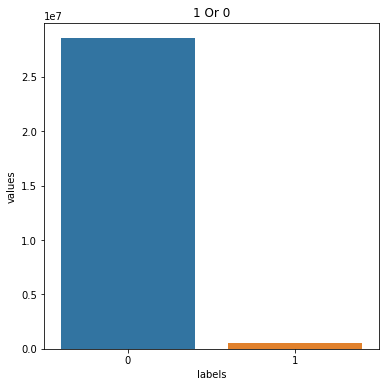

In [37]:
temp = hist_trans['date1'].value_counts()
df = pd.DataFrame({'labels':temp.index,
                'values':temp.values})
plt.figure(figsize=(6,6))
plt.title('1 Or 0')
sns.barplot(x='labels', y='values', data=df)
plt.show()

In [38]:
def func(x):
  
    if x == y1:
        return 1
    if x == y2:
        return 1
    if x == y3:
        return 1
    if x == y4:
        return 1
    if x == y5:
        return 1
    if x == y6:
        return 1
    if x == y7:
        return 1
    if x == y8:
        return 1
    if x == y9:
        return 1
    if x == y10:
        return 1
    if x == y11:
        return 1
    if x == y12:
        return 1
    if x == y13:
        return 1
    if x == y14:
        return 1
    if x == y15:
        return 1
    if x == y16:
        return 1
    if x == y17:
        return 1
    if x == y18:
        return 1
    if x == y19:
        return 1
    if x == y20:
        return 1
    if x == y21:
        return 1
    if x == y22:
        return 1
    if x == y23:
        return 1
    if x == y24:
        return 1
    if x == y25:
        return 1
    if x == y26:
        return 1
    if x == y27:
        return 1
    if x == y28:
        return 1
    if x == y29:
        return 1
    if x == y30:
        return 1
    if x == y31:
        return 1
    if x == y32:
        return 1
    if x == y33:
        return 1
    if x == y35:
        return 1
    if x == y36:
        return 1
    if x == y36:
        return 1
    if x == y37:
        return 1
    if x == y38:
        return 1
    if x == y39:
        return 1
    if x == y40:
        return 1
    if x == y41:
        return 1
    if x == y42:
        return 1
    if x == y43:
        return 1
    if x == y44:
        return 1
    if x == y45:
        return 1
    if x == y46:
        return 1
    if x == y47:
        return 1
    if x == y48:
        return 1
    if x == y49:
        return 1
    if x == y50:
        return 1
    if x == y51:
        return 1
    if x == y52:
        return 1
    if x == y53:
        return 1
    if x == y54:
        return 1
    if x == y55:
        return 1
    if x == y56:
        return 1
    if x == y57:
        return 1
    if x == y58:
        return 1
    if x == y59:
        return 1
    if x == y60:
        return 1
    if x == y61:
        return 1
    if x == y62:
        return 1
    if x == y63:
        return 1
    if x == y64:
        return 1
    if x == y65:
        return 1
    if x == y66:
        return 1
    if x == y67:
        return 1
    if x == y68:
        return 1
    if x == y69:
        return 1
    if x == y70:
        return 1
    else:
        return 0
   
new_merchant['date1']=new_merchant['date'].map(func,("2017-01-01","2017-04-16","2017-04-21","2017-05-01","2017-09-07","2017-10-12",
                                                "2017-11-02","2017-11-15","2017-11-20","2017-12-25"))

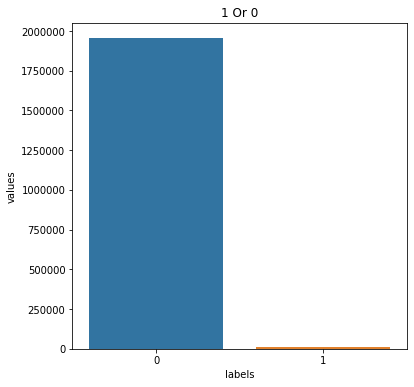

In [39]:
temp = new_merchant['date1'].value_counts()
df = pd.DataFrame({'labels':temp.index,
                'values':temp.values})
plt.figure(figsize=(6,6))
plt.title('1 Or 0')
sns.barplot(x='labels', y='values', data=df)
plt.show()

In [41]:
import datetime
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['year'] = df['first_active_month'].dt.year
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.date(2020, 1, 1) - df['first_active_month'].dt.date).dt.days

hist_trans['dayofweek'].head()

0    6
1    5
2    2
3    5
4    4
Name: dayofweek, dtype: int64

In [42]:
def aggregate_historical_transactions(history):
   
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
   
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'city_id': ['nunique'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'purchase_date': ['min','max'],
        'month_lag': ['min', 'max'],
        'working_time':['min','max'],
        'weekend':['sum','mean'],
        'date1':['sum','mean']
        }
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['hist_' + '_'.join(col).strip()
                           for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
   
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='hist_transactions_count'))
   
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
   
    return agg_history

history = aggregate_historical_transactions(hist_trans)
del hist_trans
gc.collect()

5541

In [43]:
def aggregate_new_transactions(new_trans):   
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'city_id': ['nunique'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'month_lag': ['min', 'max'],
        'working_time':['min','max'],
        'weekend':['sum','mean'],
        'date1':['sum','mean']
       
        }
    agg_new_trans = new_trans.groupby(['card_id']).agg(agg_func)
    agg_new_trans.columns = ['new_' + '_'.join(col).strip()
                           for col in agg_new_trans.columns.values]
    agg_new_trans.reset_index(inplace=True)
   
    df = (new_trans.groupby('card_id')
          .size()
          .reset_index(name='new_transactions_count'))
   
    agg_new_trans = pd.merge(df, agg_new_trans, on='card_id', how='left')
   
    return agg_new_trans

new_trans = aggregate_new_transactions(new_merchant)

In [44]:
train=pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

In [45]:
train=pd.merge(train, new_trans, on='card_id', how='left')
test = pd.merge(test, new_trans, on='card_id', how='left')

In [46]:
use_cols1 = [col for col in train.columns if col not in ['card_id', 'first_active_month']]
use_cols2 = [col for col in test.columns if col not in ['card_id', 'first_active_month']]
train = train[use_cols1]
test = test[use_cols2]

In [47]:
#pip install lightgbm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn import preprocessing
from sklearn import utils
from lightgbm import LGBMRegressor

In [48]:
y     = train['target']
train = train.drop(['target'],axis=1)

nfolds = 10
folds = KFold(n_splits=5, shuffle=True, random_state=4590)

param = {'num_leaves': 129,
         'min_data_in_leaf': 148,
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "min_child_samples": 24,
         "boosting": "gbdt",
         "feature_fraction": 0.7202,
         "bagging_freq": 1,
         "bagging_fraction": 0.8125 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.3468,
         "verbosity": -1}

In [49]:
feature_importance_df = np.zeros((train.shape[1], nfolds))
mvalid = np.zeros(len(train))
mfull  = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, train.values)):
    print('----')
    print("fold n°{}".format(fold_))
   
    x0,y0 = train.iloc[trn_idx], y[trn_idx]
    x1,y1 = train.iloc[val_idx], y[val_idx]
   
    trn_data = lgb.Dataset(x0, label= y0); val_data = lgb.Dataset(x1, label= y1)
   
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],
                    verbose_eval=500, early_stopping_rounds = 150)
    mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)
   
    feature_importance_df[:, fold_] = clf.feature_importance()
   
    mfull += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
   
np.sqrt(mean_squared_error(mvalid, y))

----
fold n°0
Training until validation scores don't improve for 150 rounds
[500]	training's rmse: 3.56179	valid_1's rmse: 3.76627
[1000]	training's rmse: 3.49695	valid_1's rmse: 3.75672
[1500]	training's rmse: 3.45247	valid_1's rmse: 3.75539
Early stopping, best iteration is:
[1636]	training's rmse: 3.44091	valid_1's rmse: 3.75527
----
fold n°1
Training until validation scores don't improve for 150 rounds
[500]	training's rmse: 3.59268	valid_1's rmse: 3.63876
[1000]	training's rmse: 3.52437	valid_1's rmse: 3.63112
[1500]	training's rmse: 3.48075	valid_1's rmse: 3.6302
Early stopping, best iteration is:
[1513]	training's rmse: 3.47961	valid_1's rmse: 3.63014
----
fold n°2
Training until validation scores don't improve for 150 rounds
[500]	training's rmse: 3.58552	valid_1's rmse: 3.6664
[1000]	training's rmse: 3.5187	valid_1's rmse: 3.65973
Early stopping, best iteration is:
[984]	training's rmse: 3.52021	valid_1's rmse: 3.65961
----
fold n°3
Training until validation scores don't impro

3.6781640981990917